In [3]:
import sys
sys.path.append('C:/Users/User/brain tumor 2/Brain-MRI-segmentation')


In [34]:
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import MultiStepLR

from UNet import UNet
from MRIDataset import MRIDataset
from DiceLoss import DiceLoss
import os
import glob
import cv2
import numpy as np
import pandas as pd
import gc
import time
from PIL import Image


In [70]:
metadata = pd.read_csv(r'C:\Users\User\BrainTumor_final\kaggle_3m\data.csv')
display(metadata)
metadata.info()

Patient  RNASeqCluster  MethylationCluster  miRNACluster  CNCluster  \
0    TCGA_CS_4941            2.0                 4.0             2        2.0   
1    TCGA_CS_4942            1.0                 5.0             2        1.0   
2    TCGA_CS_4943            1.0                 5.0             2        1.0   
3    TCGA_CS_4944            NaN                 5.0             2        1.0   
4    TCGA_CS_5393            4.0                 5.0             2        1.0   
..            ...            ...                 ...           ...        ...   
105  TCGA_HT_8563            2.0                 5.0             3        1.0   
106  TCGA_HT_A5RC            2.0                 4.0             2        2.0   
107  TCGA_HT_A616            NaN                 5.0             2        1.0   
108  TCGA_HT_A61A            NaN                 5.0             2        NaN   
109  TCGA_HT_A61B            NaN                 5.0             2        1.0   

     RPPACluster  OncosignCluster  COCCluster  histological_type  \
0            NaN              3.0           2                1.0   
1            1.0              2.0           1                1.0   
2            2.0              2.0           1                1.0   
3            2.0              1.0           1                1.0   
4            2.0              3.0           1                1.0   
..           ...              ...         ...                ...   
105          NaN              2.0           2                1.0   
106          NaN              3.0           2                1.0   
107          NaN              2.0           1                1.0   
108          NaN              NaN           1                3.0   
109          NaN              2.0           1                NaN   

     neoplasm_histologic_grade  tumor_tissue_site  laterality  tumor_location  \
0                          2.0                1.0         3.0             2.0   
1                          2.0                1.0         3.0             2.0   
2                          2.0                1.0         1.0             2.0   
3                          1.0                1.0         3.0             6.0   
4                          2.0                1.0         1.0             6.0   
..                         ...                ...         ...             ...   
105                        2.0                1.0         3.0             2.0   
106                        2.0                1.0         1.0             2.0   
107                        1.0                1.0         1.0             2.0   
108                        1.0                1.0         1.0             6.0   
109                        NaN                NaN         NaN             NaN   

     gender  age_at_initial_pathologic  race  ethnicity  death01  
0       2.0                       67.0   3.0        2.0      1.0  
1       1.0                       44.0   2.0        NaN      1.0  
2       2.0                       37.0   3.0        NaN      0.0  
3       2.0                       50.0   3.0        NaN      0.0  
4       2.0                       39.0   3.0        NaN      0.0  
..      ...                        ...   ...        ...      ...  
105     1.0                       30.0   3.0        2.0      0.0  
106     1.0                       70.0   3.0        2.0      1.0  
107     1.0                       36.0   3.0        2.0      0.0  
108     1.0                       20.0   3.0        2.0      0.0  
109     NaN                        NaN   NaN        NaN      NaN  

[110 rows x 18 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [97]:
import os
import glob
import pandas as pd

data_map = []
for sub_dir_path in glob.glob(r'C:\Users\User\BrainTumor_final/kaggle_3m/*'):
    if os.path.isdir(sub_dir_path):
        dirname = sub_dir_path.split("/")[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + "/" + filename
            data_map.extend([dirname, image_path])

df = pd.DataFrame({
    "patient_id" : data_map[::2],
    "path" : data_map[1::2]
})

df

patient_id  \
0     kaggle_3m\TCGA_CS_4941_19960909   
1     kaggle_3m\TCGA_CS_4941_19960909   
2     kaggle_3m\TCGA_CS_4941_19960909   
3     kaggle_3m\TCGA_CS_4941_19960909   
4     kaggle_3m\TCGA_CS_4941_19960909   
...                               ...   
7853  kaggle_3m\TCGA_HT_A61B_19991127   
7854  kaggle_3m\TCGA_HT_A61B_19991127   
7855  kaggle_3m\TCGA_HT_A61B_19991127   
7856  kaggle_3m\TCGA_HT_A61B_19991127   
7857  kaggle_3m\TCGA_HT_A61B_19991127   

                                                   path  
0     C:\Users\User\BrainTumor_final/kaggle_3m\TCGA_...  
1     C:\Users\User\BrainTumor_final/kaggle_3m\TCGA_...  
2     C:\Users\User\BrainTumor_final/kaggle_3m\TCGA_...  
3     C:\Users\User\BrainTumor_final/kaggle_3m\TCGA_...  
4     C:\Users\User\BrainTumor_final/kaggle_3m\TCGA_...  
...                                                 ...  
7853  C:\Users\User\BrainTumor_final/kaggle_3m\TCGA_...  
7854  C:\Users\User\BrainTumor_final/kaggle_3m\TCGA_...  
7855  C:\Users\User\BrainTumor_final/kaggle_3m\TCGA_...  
7856  C:\Users\User\BrainTumor_final/kaggle_3m\TCGA_...  
7857  C:\Users\User\BrainTumor_final/kaggle_3m\TCGA_...  

[7858 rows x 2 columns]

In [99]:
import os
import cv2
import pandas as pd
import numpy as np

df_images = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

def extract_number_from_path(path):
    try:
        filename = os.path.basename(path)
        number = filename.split("_")[-1].split(".")[0]
        return int(number)
    except ValueError:
        return -1

images = sorted(df_images["path"].values, key=lambda x: extract_number_from_path(x))
masks = sorted(df_masks["path"].values, key=lambda x: extract_number_from_path(x))

if len(images) != len(masks):
    raise ValueError("Mismatch in the number of images and masks!")

df_brain = pd.DataFrame({
    "patient_id": df_images["patient_id"].values[:len(images)],
    "image_path": images,
    "mask_path": masks
})

def pos_neg_diagnosis(mask_path):
    try:
        value = np.max(cv2.imread(mask_path))
        return 1 if value > 0 else 0
    except Exception as e:
        print(f"Error processing mask: {mask_path}, Error: {e}")
        return 0

df_brain["diagnosis"] = df_brain["mask_path"].apply(pos_neg_diagnosis)

print(df_brain.head())
print(f"Total rows in df_brain: {len(df_brain)}")


                        patient_id  \
0  kaggle_3m\TCGA_CS_4941_19960909   
1  kaggle_3m\TCGA_CS_4941_19960909   
2  kaggle_3m\TCGA_CS_4941_19960909   
3  kaggle_3m\TCGA_CS_4941_19960909   
4  kaggle_3m\TCGA_CS_4941_19960909   

                                          image_path  \
0  C:\Users\User\BrainTumor_final/kaggle_3m\TCGA_...   
1  C:\Users\User\BrainTumor_final/kaggle_3m\TCGA_...   
2  C:\Users\User\BrainTumor_final/kaggle_3m\TCGA_...   
3  C:\Users\User\BrainTumor_final/kaggle_3m\TCGA_...   
4  C:\Users\User\BrainTumor_final/kaggle_3m\TCGA_...   

                                           mask_path  diagnosis  
0  C:\Users\User\BrainTumor_final/kaggle_3m\TCGA_...          0  
1  C:\Users\User\BrainTumor_final/kaggle_3m\TCGA_...          1  
2  C:\Users\User\BrainTumor_final/kaggle_3m\TCGA_...          1  
3  C:\Users\User\BrainTumor_final/kaggle_3m\TCGA_...          1  
4  C:\Users\User\BrainTumor_final/kaggle_3m\TCGA_...          1  
Total rows in df_brain: 3929


In [101]:
import os
import cv2
import pandas as pd
import numpy as np

df_images = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

BASE_LEN = 83
END_IMG_LEN = 4
END_MASK_LEN = 9

def safe_extract_number(path, base_len, end_len):
    try:
        numeric_part = path[base_len:-end_len]
        return int(numeric_part)
    except ValueError:
        print(f"Invalid path: {path}")
        return -1

images = sorted(df_images["path"].values, key=lambda x: safe_extract_number(x, BASE_LEN, END_IMG_LEN))
masks = sorted(df_masks["path"].values, key=lambda x: safe_extract_number(x, BASE_LEN, END_MASK_LEN))

if len(images) != len(masks):
    raise ValueError("Mismatch in the number of images and masks!")

df_brain = pd.DataFrame({
    "patient_id": df_images["patient_id"].values[:len(images)],
    "image_path": images,
    "mask_path": masks
})

def pos_neg_diagnosis(mask_path):
    try:
        value = np.max(cv2.imread(mask_path))
        return 1 if value > 0 else 0
    except Exception as e:
        print(f"Error processing mask: {mask_path}, Error: {e}")
        return 0

df_brain["diagnosis"] = df_brain["mask_path"].apply(pos_neg_diagnosis)

from IPython.display import display
display(df_brain.head())

df_brain.to_csv("processed_mri_dataset.csv", index=False)
print(f"Total rows in df_brain: {len(df_brain)}")


patient_id  \
0  kaggle_3m\TCGA_CS_4941_19960909   
1  kaggle_3m\TCGA_CS_4941_19960909   
2  kaggle_3m\TCGA_CS_4941_19960909   
3  kaggle_3m\TCGA_CS_4941_19960909   
4  kaggle_3m\TCGA_CS_4941_19960909   

                                          image_path  \
0  C:\Users\User\BrainTumor_final/kaggle_3m\TCGA_...   
1  C:\Users\User\BrainTumor_final/kaggle_3m\TCGA_...   
2  C:\Users\User\BrainTumor_final/kaggle_3m\TCGA_...   
3  C:\Users\User\BrainTumor_final/kaggle_3m\TCGA_...   
4  C:\Users\User\BrainTumor_final/kaggle_3m\TCGA_...   

                                           mask_path  diagnosis  
0  C:\Users\User\BrainTumor_final/kaggle_3m\TCGA_...          0  
1  C:\Users\User\BrainTumor_final/kaggle_3m\TCGA_...          0  
2  C:\Users\User\BrainTumor_final/kaggle_3m\TCGA_...          0  
3  C:\Users\User\BrainTumor_final/kaggle_3m\TCGA_...          0  
4  C:\Users\User\BrainTumor_final/kaggle_3m\TCGA_...          0

Total rows in df_brain: 3929


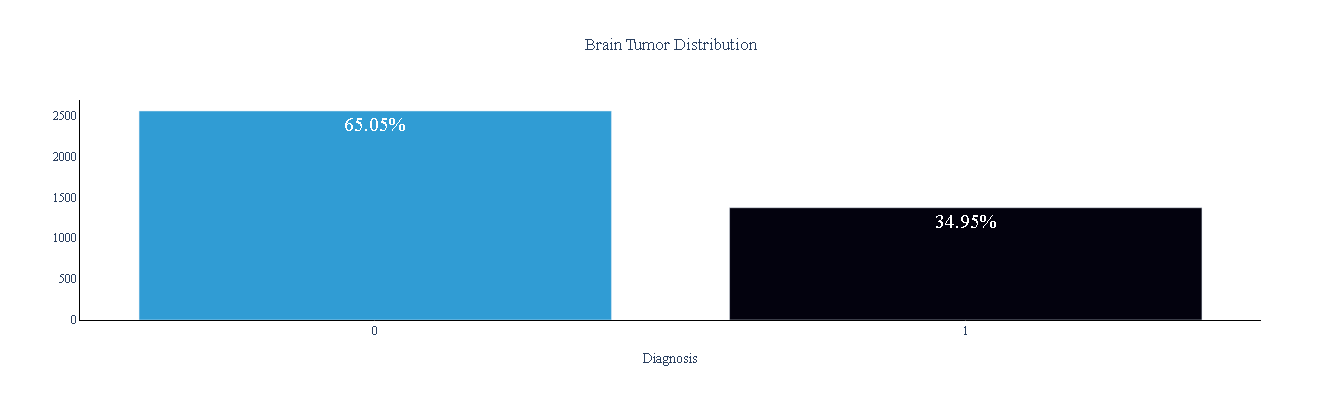

In [103]:
import plotly
import plotly.graph_objects as go
fig = go.Figure()

diagnosis_count = df_brain["diagnosis"].value_counts()
diagnosis_percentage = (diagnosis_count / diagnosis_count.sum()) * 100
fig.add_trace(
    go.Bar(
        x=[str(x) for x in diagnosis_count.index.tolist()],
        y=diagnosis_count.values,
        marker_color=["#309cd4", "#03020e"],
        text=[f"{percentage:.2f}%" for percentage in diagnosis_percentage],
        textfont_size=20,
        textfont_color="white"
    )
)

fig.update_xaxes(showgrid=False, linecolor='black', title_text='Diagnosis')
fig.update_yaxes(showgrid=False, linecolor='black')

fig.update_layout(title_text="Brain Tumor Distribution", title_x=0.5, font_family="Times New Roman",
                  width=600, height=400,
                  plot_bgcolor='White'
)

# Show
fig.show(iframe="connected")

In [88]:
df_patient_tumor = df_brain[df_brain["diagnosis"]==1].reset_index(drop=True)
df_patient_num_dns = df_patient_tumor.groupby("patient_id")["diagnosis"].sum().reset_index().sort_values(by="diagnosis", ascending=False).reset_index(drop=True)
patient_id = df_patient_num_dns[df_patient_num_dns["diagnosis"]==11]["patient_id"].iloc[0, ]
df_patient_one = df_brain[df_brain["patient_id"]==patient_id].reset_index(drop=True)
display(df_patient_one.head())
df_patient_one.shape

patient_id  \
0  kaggle_3m\TCGA_DU_8167_19970402   
1  kaggle_3m\TCGA_DU_8167_19970402   
2  kaggle_3m\TCGA_DU_8167_19970402   
3  kaggle_3m\TCGA_DU_8167_19970402   
4  kaggle_3m\TCGA_DU_8167_19970402   

                                          image_path  \
0  C:\Users\User\BrainTumor_final/kaggle_3m\TCGA_...   
1  C:\Users\User\BrainTumor_final/kaggle_3m\TCGA_...   
2  C:\Users\User\BrainTumor_final/kaggle_3m\TCGA_...   
3  C:\Users\User\BrainTumor_final/kaggle_3m\TCGA_...   
4  C:\Users\User\BrainTumor_final/kaggle_3m\TCGA_...   

                                           mask_path  diagnosis  
0  C:\Users\User\BrainTumor_final/kaggle_3m\TCGA_...          0  
1  C:\Users\User\BrainTumor_final/kaggle_3m\TCGA_...          0  
2  C:\Users\User\BrainTumor_final/kaggle_3m\TCGA_...          1  
3  C:\Users\User\BrainTumor_final/kaggle_3m\TCGA_...          0  
4  C:\Users\User\BrainTumor_final/kaggle_3m\TCGA_...          0

(37, 4)

In [91]:
print(df_patient_tumor["diagnosis"].value_counts())
print(df_brain["diagnosis"].value_counts())


diagnosis
1    1373
Name: count, dtype: int64
diagnosis
0    2556
1    1373
Name: count, dtype: int64


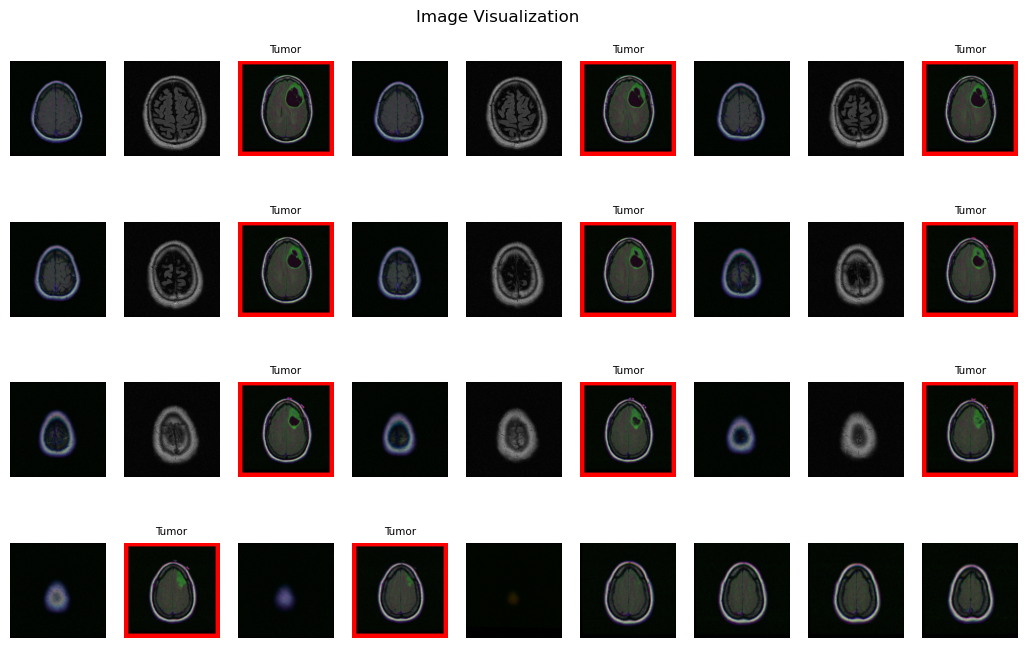

In [105]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image

def frame_image(img, frame_width):
    b = frame_width
    ny, nx = img.shape[0], img.shape[1]
    framed_img = Image.new('RGB', (nx + 2*b, ny + 2*b), (255, 0, 0))
    framed_img = np.array(framed_img)
    framed_img[b:-b, b:-b] = img
    return framed_img

n_images = min(df_patient_one.shape[0], 36)

fig, axs = plt.subplots(4, 9, figsize=(13, 8))

for i in range(n_images):
    mri_sm = cv2.imread(df_patient_one["image_path"].iloc[i])[:, :, ::-1]
    if df_patient_one["diagnosis"].iloc[i] == 1:
        axs[i // 9, i % 9].imshow(frame_image(mri_sm, 13))
        axs[i // 9, i % 9].set_title("Tumor", fontsize=7.5)
    else:
        axs[i // 9, i % 9].imshow(mri_sm)

    axs[i // 9, i % 9].axis("off")

for j in range(n_images, 4 * 9):
    axs[j // 9, j % 9].axis("off")

plt.suptitle("Image Visualization", x=0.5, y=0.92)
plt.show()


# UNet

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_dataset = MRIDataset()
train_loader = DataLoader(
    train_dataset,
    batch_size = 8,
    shuffle = True
)

val_dataset = MRIDataset(train=False)
val_loader = DataLoader(
    val_dataset,
    batch_size = 8,
    shuffle = False
)

net = UNet(in_channels=3, out_channels=1, depth=4)
net.to(device)

criterion = DiceLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
scheduler = MultiStepLR(optimizer, milestones=[10,], gamma=0.1)

n_epochs = 20

In [8]:
train_losses = []
val_losses = []

best_loss = 1
ebar = tqdm(total=n_epochs, desc=f"Loss: 0 [0]", leave=False)
for epoch in range(n_epochs):
    net.train()

    train_loss = 0
    ibar = tqdm(total=len(train_loader), desc="Loss: 0", leave=False)
    for x, y_true in train_loader:
        x, y_true = x.to(device), y_true.to(device)

        optimizer.zero_grad()

        y_pred = net(x)
        loss = criterion(y_pred, y_true)

        train_losses.append(loss.item())
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        ibar.set_description(f"Trainining loss: {loss.item():.03f}")
        ibar.update(1)
    ibar.close()
    
    scheduler.step()
    
    net.eval()
    val_loss = 0
    ibar = tqdm(total=len(val_loader), desc="Loss: 0", leave=False)
    with torch.no_grad():
        for x, y_true in val_loader:
            x, y_true = x.to(device), y_true.to(device)
            y_pred = net(x)
            loss = criterion(y_pred, y_true)
            val_losses.append(loss.item())
            val_loss += loss.item()
            ibar.set_description(f"Validation loss: {loss.item():.03f}")
            ibar.update(1)
        ibar.close()
        
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    ebar.set_description(f"Loss: {train_loss:.03f} [{val_loss:.03f}]")
    ebar.update(1)
    
    if (val_loss <= best_loss):
        best_loss = val_loss
        torch.save({
            'epoch': epoch,
            'state_dict': net.state_dict(),
            'val_loss': val_loss,
            'train_loss': train_loss,
            'train_losses': train_losses,  
            'val_losses': val_losses       
            }, 
            'unet.pt'
        )

ebar.close()


Loss: 0 [0]:   0%|          | 0/20 [00:00<?, ?it/s]

Loss: 0:   0%|          | 0/410 [00:00<?, ?it/s]

Loss: 0:   0%|          | 0/95 [00:00<?, ?it/s]

Loss: 0:   0%|          | 0/410 [00:00<?, ?it/s]

Loss: 0:   0%|          | 0/95 [00:00<?, ?it/s]

Loss: 0:   0%|          | 0/410 [00:00<?, ?it/s]

Loss: 0:   0%|          | 0/95 [00:00<?, ?it/s]

Loss: 0:   0%|          | 0/410 [00:00<?, ?it/s]

Loss: 0:   0%|          | 0/95 [00:00<?, ?it/s]

Loss: 0:   0%|          | 0/410 [00:00<?, ?it/s]

Loss: 0:   0%|          | 0/95 [00:00<?, ?it/s]

Loss: 0:   0%|          | 0/410 [00:00<?, ?it/s]

Loss: 0:   0%|          | 0/95 [00:00<?, ?it/s]

Loss: 0:   0%|          | 0/410 [00:00<?, ?it/s]

Loss: 0:   0%|          | 0/95 [00:00<?, ?it/s]

Loss: 0:   0%|          | 0/410 [00:00<?, ?it/s]

Loss: 0:   0%|          | 0/95 [00:00<?, ?it/s]

Loss: 0:   0%|          | 0/410 [00:00<?, ?it/s]

Loss: 0:   0%|          | 0/95 [00:00<?, ?it/s]

Loss: 0:   0%|          | 0/410 [00:00<?, ?it/s]

Loss: 0:   0%|          | 0/95 [00:00<?, ?it/s]

Loss: 0:   0%|          | 0/410 [00:00<?, ?it/s]

Loss: 0:   0%|          | 0/95 [00:00<?, ?it/s]

Loss: 0:   0%|          | 0/410 [00:00<?, ?it/s]

Loss: 0:   0%|          | 0/95 [00:00<?, ?it/s]

Loss: 0:   0%|          | 0/410 [00:00<?, ?it/s]

Loss: 0:   0%|          | 0/95 [00:00<?, ?it/s]

Loss: 0:   0%|          | 0/410 [00:00<?, ?it/s]

Loss: 0:   0%|          | 0/95 [00:00<?, ?it/s]

Loss: 0:   0%|          | 0/410 [00:00<?, ?it/s]

Loss: 0:   0%|          | 0/95 [00:00<?, ?it/s]

Loss: 0:   0%|          | 0/410 [00:00<?, ?it/s]

Loss: 0:   0%|          | 0/95 [00:00<?, ?it/s]

Loss: 0:   0%|          | 0/410 [00:00<?, ?it/s]

Loss: 0:   0%|          | 0/95 [00:00<?, ?it/s]

Loss: 0:   0%|          | 0/410 [00:00<?, ?it/s]

Loss: 0:   0%|          | 0/95 [00:00<?, ?it/s]

Loss: 0:   0%|          | 0/410 [00:00<?, ?it/s]

Loss: 0:   0%|          | 0/95 [00:00<?, ?it/s]

Loss: 0:   0%|          | 0/410 [00:00<?, ?it/s]

Loss: 0:   0%|          | 0/95 [00:00<?, ?it/s]

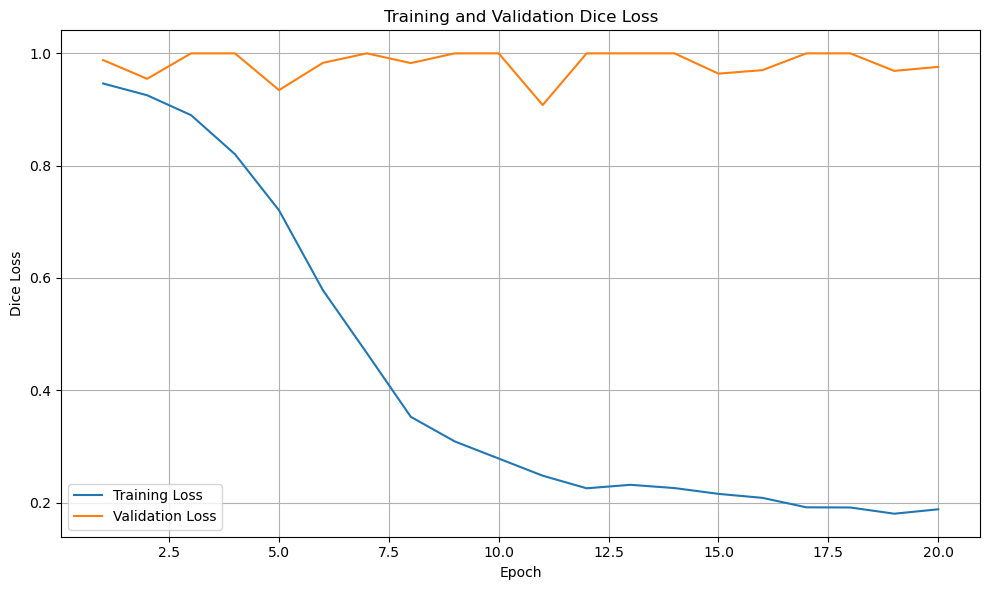

In [42]:
train_losses = train_losses[:380 * 20] 
train_losses_per_epoch = np.array(train_losses).reshape(20, 380).mean(axis=1)

if len(val_losses) > 20:
    val_losses = val_losses[:20]  
elif len(val_losses) < 20:
    
    val_losses = np.array(val_losses + [np.mean(val_losses)] * (20 - len(val_losses)))

assert len(val_losses) == 20, "Validation losses must match the number of epochs."

plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), train_losses_per_epoch, label='Training Loss')
plt.plot(range(1, 21), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Dice Loss')
plt.title('Training and Validation Dice Loss')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [50]:
import sys
import os
sys.path.append(r"C:\Users\User\brain tumor 2\Brain-MRI-segmentation\BrainMRISegmentation")

from IoU_metric import IoU_metric_from_dice


# Calculating IoU and Dice( UNet )

C:\Users\User\AppData\Local\Temp\ipykernel_19508\3834063352.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load('unet.pt', map_location=device)
Clipping in

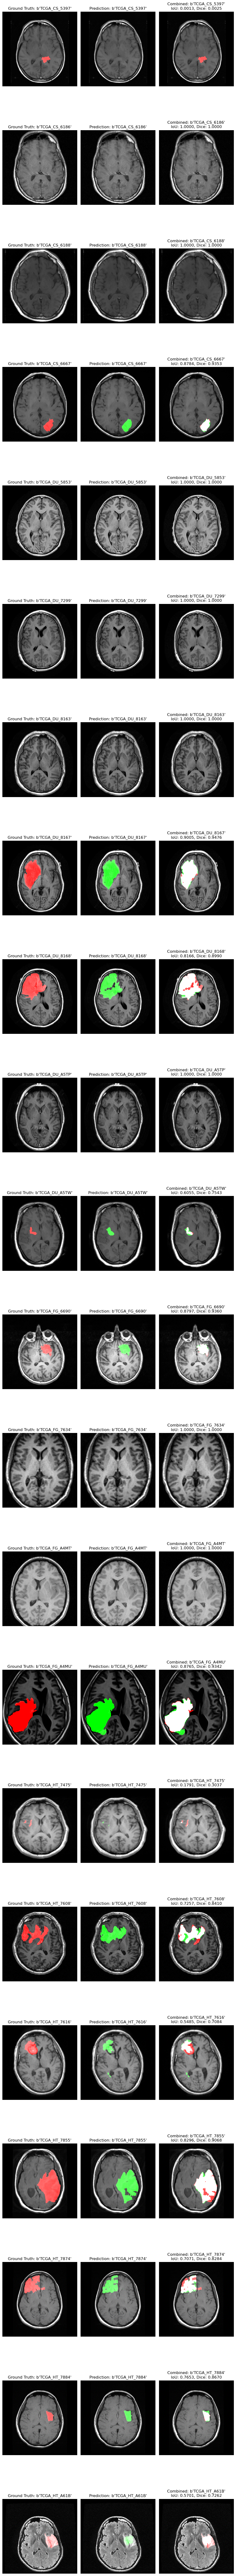

Mean IoU: 0.7856
Mean Dice: 0.8450


In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = UNet(in_channels=3, out_channels=1, depth=4).to(device)
ckpt = torch.load('unet.pt', map_location=device)
net.load_state_dict(ckpt['state_dict'])
net.eval()

ious = []
dices = []

patients, counts = np.unique(val_dataset.dataset.patients, return_counts=True)
fig, ax = plt.subplots(len(patients), 3, figsize=(10, len(patients) * 5))

for i, patient in enumerate(patients):
    idx = np.sum(counts[:i]) + counts[i] // 2
    with torch.no_grad():
        x, y_true = val_dataset[idx]
        x, y_true = x.to(device), y_true.to(device)
        x = x.unsqueeze(0)
        y_pred = net(x)

    y_pred = y_pred.squeeze(0).cpu().numpy()
    y_true = y_true.cpu().numpy()

    if y_pred.ndim > 2:
        y_pred_binary = (y_pred > 0.5).astype(np.uint8).squeeze(0)
    else:
        y_pred_binary = (y_pred > 0.5).astype(np.uint8)

    if y_true.ndim > 2:
        y_true = y_true.squeeze(0)

    dice = 1 - DiceLoss()(torch.tensor(y_pred_binary).unsqueeze(0).unsqueeze(0), torch.tensor(y_true).unsqueeze(0).unsqueeze(0)).item()
    dices.append(dice)

    iou = IoU_metric_from_dice(dice)
    ious.append(iou)

    img = x.squeeze(0).permute(1, 2, 0).cpu().numpy()
    img_true = np.stack([img[..., 0], img[..., 0], img[..., 0]], axis=-1)
    img_pred = img_true.copy()
    img_combined = img_true.copy()

    img_true[..., 0][y_true == 1] = 255
    img_pred[..., 1][y_pred_binary == 1] = 255
    img_combined[..., 0][y_true == 1] = 255
    img_combined[..., 1][y_pred_binary == 1] = 255
    img_combined[..., 2][(y_true == 1) & (y_pred_binary == 1)] = 255

    ax[i][0].imshow(img_true)
    ax[i][0].set_title(f"Ground Truth: {patient}")
    ax[i][0].axis('off')

    ax[i][1].imshow(img_pred)
    ax[i][1].set_title(f"Prediction: {patient}")
    ax[i][1].axis('off')

    ax[i][2].imshow(img_combined)
    ax[i][2].set_title(f"Combined: {patient}\nIoU: {iou:.4f}, Dice: {dice:.4f}")
    ax[i][2].axis('off')

plt.tight_layout()
plt.show()

mean_iou = np.mean(ious)
mean_dice = np.mean(dices)

print(f"Mean IoU: {mean_iou:.4f}")
print(f"Mean Dice: {mean_dice:.4f}")


In [54]:
ious = []
dices = []

for idx in range(len(val_dataset)):
    with torch.no_grad():
        x, y_true = val_dataset[idx]
        x, y_true = x.to(device), y_true.to(device)
        x = x.unsqueeze(0)  
        y_pred = net(x)

    y_pred = y_pred.squeeze(0).cpu().numpy()  
    y_true = y_true.cpu().numpy()

    if y_pred.ndim > 2:
        y_pred_binary = (y_pred > 0.5).astype(np.uint8).squeeze(0) 
    else:
        y_pred_binary = (y_pred > 0.5).astype(np.uint8)

    if y_true.ndim > 2:
        y_true = y_true.squeeze(0) 

    dice = 1 - DiceLoss()(torch.tensor(y_pred_binary).unsqueeze(0).unsqueeze(0), torch.tensor(y_true).unsqueeze(0).unsqueeze(0)).item()
    dices.append(dice)

    
    iou = IoU_metric_from_dice(dice)
    ious.append(iou)

mean_iou = np.mean(ious)
mean_dice = np.mean(dices)

print(f"Final Mean IoU: {mean_iou:.4f}")
print(f"Final Mean Dice (Full Dataset): {mean_dice:.4f}")


Final Mean IoU: 0.8692
Final Mean Dice (Full Dataset): 0.9004


# DeepLabV3+

In [107]:
from tqdm import tqdm
from torch.optim.lr_scheduler import MultiStepLR
from deeplab import DeepLabV3Plus

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deeplab = DeepLabV3Plus(in_channels=3, out_channels=1).to(device)
criterion = DiceLoss() 
optimizer = torch.optim.Adam(deeplab.parameters(), lr=1e-4)
scheduler = MultiStepLR(optimizer, milestones=[10], gamma=0.1)
n_epochs = 20

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_dataset = MRIDataset()
train_loader = DataLoader(
    train_dataset,
    batch_size = 8,
    shuffle = True
)

val_dataset = MRIDataset(train=False)
val_loader = DataLoader(
    val_dataset,
    batch_size = 8,
    shuffle = False
)

In [101]:
train_losses = []
val_losses = []

best_loss = 1
ebar = tqdm(total=n_epochs, desc=f"Loss: 0 [0]", leave=False)

for epoch in range(n_epochs):
    deeplab.train()
    train_loss = 0
    epoch_train_losses = []
    epoch_val_losses = []

    ibar = tqdm(total=len(train_loader), desc="Loss: 0", leave=False)
    for x, y_true in train_loader:
        x, y_true = x.to(device), y_true.to(device)

        optimizer.zero_grad()
        y_pred = deeplab(x)
        loss = criterion(y_pred, y_true)

        epoch_train_losses.append(loss.item())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        ibar.set_description(f"Trainining loss: {loss.item():.03f}")
        ibar.update(1)
    ibar.close()

    scheduler.step()

    deeplab.eval()
    val_loss = 0
    ibar = tqdm(total=len(val_loader), desc="Loss: 0", leave=False)
    with torch.no_grad():
        for x, y_true in val_loader:
            x, y_true = x.to(device), y_true.to(device)
            y_pred = deeplab(x)
            loss = criterion(y_pred, y_true)
            epoch_val_losses.append(loss.item())
            val_loss += loss.item()
            ibar.set_description(f"Validation loss: {loss.item():.03f}")
            ibar.update(1)
        ibar.close()

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)

    train_losses.append(np.mean(epoch_train_losses))
    val_losses.append(np.mean(epoch_val_losses))

    ebar.set_description(f"Loss: {train_loss:.03f} [{val_loss:.03f}]")
    ebar.update(1)

    if val_loss <= best_loss:
        best_loss = val_loss
        torch.save({
            'epoch': epoch,
            'state_dict': deeplab.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
            'val_loss': val_loss,
            'train_loss': train_loss
        }, 'deeplab.pt')

ebar.close()



Loss: 0:   0%|          | 0/410 [00:00<?, ?it/s]   


                                                                         [A
Loss: 0.952 [0.932]:   0%|          | 0/20 [01:24<?, ?it/s]
                                                                         
Loss: 0.620 [0.617]:   5%|▌         | 1/20 [02:46<26:36, 84.04s/it]
                                                                         
Loss: 0.513 [0.567]:  10%|█         | 2/20 [04:08<24:52, 82.91s/it]
                                                                         
Loss: 0.469 [0.548]:  15%|█▌        | 3/20 [05:32<23:27, 82.79s/it]
                                                                         
Loss: 0.467 [0.553]:  20%|██        | 4/20 [06:56<22:07, 82.99s/it]
                                                                         
Loss: 0.441 [0.516]:  25%|██▌       | 5/20 [08:20<20:51, 83.42s/it]
                                                                         
Loss: 0.440 [0.540]:  30%

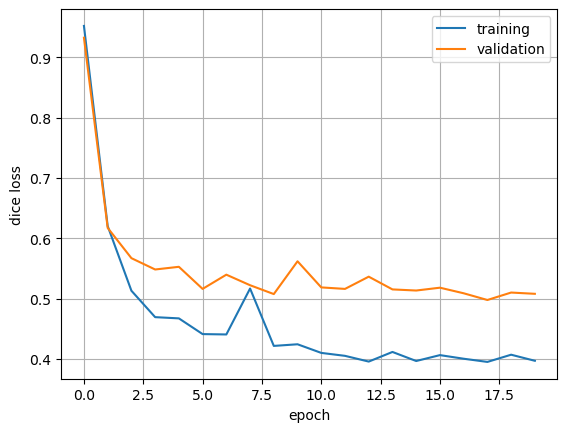

In [105]:
plt.plot(np.mean(np.array(train_losses).reshape(n_epochs, -1), axis=1), label='training')
plt.plot(val_losses, label='validation')
plt.xlabel('epoch')
plt.ylabel('dice loss')
plt.legend()
plt.grid()
plt.show()

# Calculating IoU and Dice( DeepLabV3+ )

In [111]:
from IoU_metric import IoU_metric_from_dice
from DiceLoss import DiceLoss
import torch
import numpy as np
from matplotlib import pyplot as plt

C:\Users\User\AppData\Local\Temp\ipykernel_11648\2596124532.py:4: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

Clipping input data to the valid range for imshow with RGB da

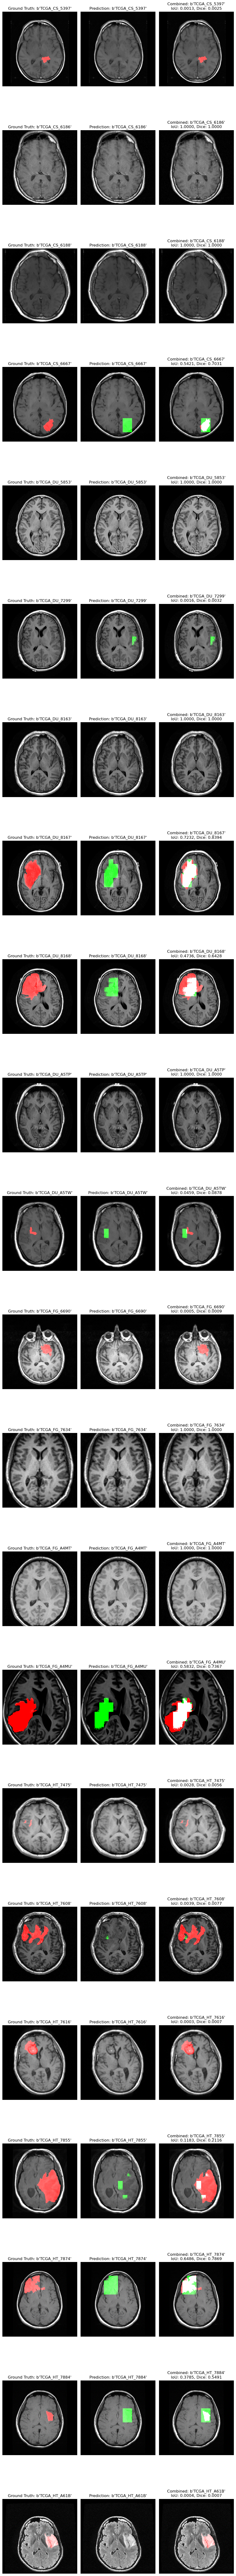

Mean IoU: 0.4784
Mean Dice: 0.5263


In [113]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = DeepLabV3Plus(in_channels=3, out_channels=1).to(device)
ckpt = torch.load('deeplab.pt', map_location=device)
net.load_state_dict(ckpt['state_dict'])
net.eval()

ious = []
dices = []

patients, counts = np.unique(val_dataset.dataset.patients, return_counts=True)
fig, ax = plt.subplots(len(patients), 3, figsize=(10, len(patients) * 5))

for i, patient in enumerate(patients):
    idx = np.sum(counts[:i]) + counts[i] // 2
    with torch.no_grad():
        x, y_true = val_dataset[idx]
        x, y_true = x.to(device), y_true.to(device)
        x = x.unsqueeze(0)
        y_pred = net(x)

    y_pred = y_pred.squeeze(0).cpu().numpy()
    y_true = y_true.cpu().numpy()

    if y_pred.ndim > 2:
        y_pred_binary = (y_pred > 0.5).astype(np.uint8).squeeze(0)
    else:
        y_pred_binary = (y_pred > 0.5).astype(np.uint8)

    if y_true.ndim > 2:
        y_true = y_true.squeeze(0)

    dice = 1 - DiceLoss()(torch.tensor(y_pred_binary).unsqueeze(0).unsqueeze(0), torch.tensor(y_true).unsqueeze(0).unsqueeze(0)).item()
    dices.append(dice)

    iou = IoU_metric_from_dice(dice)
    ious.append(iou)

    img = x.squeeze(0).permute(1, 2, 0).cpu().numpy()
    img_true = np.stack([img[..., 0], img[..., 0], img[..., 0]], axis=-1)
    img_pred = img_true.copy()
    img_combined = img_true.copy()

    img_true[..., 0][y_true == 1] = 255
    img_pred[..., 1][y_pred_binary == 1] = 255
    img_combined[..., 0][y_true == 1] = 255
    img_combined[..., 1][y_pred_binary == 1] = 255
    img_combined[..., 2][(y_true == 1) & (y_pred_binary == 1)] = 255

    ax[i][0].imshow(img_true)
    ax[i][0].set_title(f"Ground Truth: {patient}")
    ax[i][0].axis('off')

    ax[i][1].imshow(img_pred)
    ax[i][1].set_title(f"Prediction: {patient}")
    ax[i][1].axis('off')

    ax[i][2].imshow(img_combined)
    ax[i][2].set_title(f"Combined: {patient}\nIoU: {iou:.4f}, Dice: {dice:.4f}")
    ax[i][2].axis('off')

plt.tight_layout()
plt.show()

mean_iou = np.mean(ious)
mean_dice = np.mean(dices)

print(f"Mean IoU: {mean_iou:.4f}")
print(f"Mean Dice: {mean_dice:.4f}")


In [114]:
ious = []
dices = []

for idx in range(len(val_dataset)):
    with torch.no_grad():
        x, y_true = val_dataset[idx]
        x, y_true = x.to(device), y_true.to(device)
        x = x.unsqueeze(0)
        y_pred = deeplab(x)

    y_pred = y_pred.squeeze(0).cpu().numpy()
    y_true = y_true.cpu().numpy()

    if y_pred.ndim > 2:
        y_pred_binary = (y_pred > 0.5).astype(np.uint8).squeeze(0)
    else:
        y_pred_binary = (y_pred > 0.5).astype(np.uint8)

    if y_true.ndim > 2:
        y_true = y_true.squeeze(0)

    dice = 1 - DiceLoss()(
        torch.tensor(y_pred_binary).unsqueeze(0).unsqueeze(0),
        torch.tensor(y_true).unsqueeze(0).unsqueeze(0)
    ).item()
    dices.append(dice)

    iou = IoU_metric_from_dice(dice)
    ious.append(iou)

mean_iou = np.mean(ious)
mean_dice = np.mean(dices)

print(f"Final Mean IoU: {mean_iou:.4f}")
print(f"Final Mean Dice: {mean_dice:.4f}")


Final Mean IoU: 0.6880
Final Mean Dice: 0.7235


# Comparison

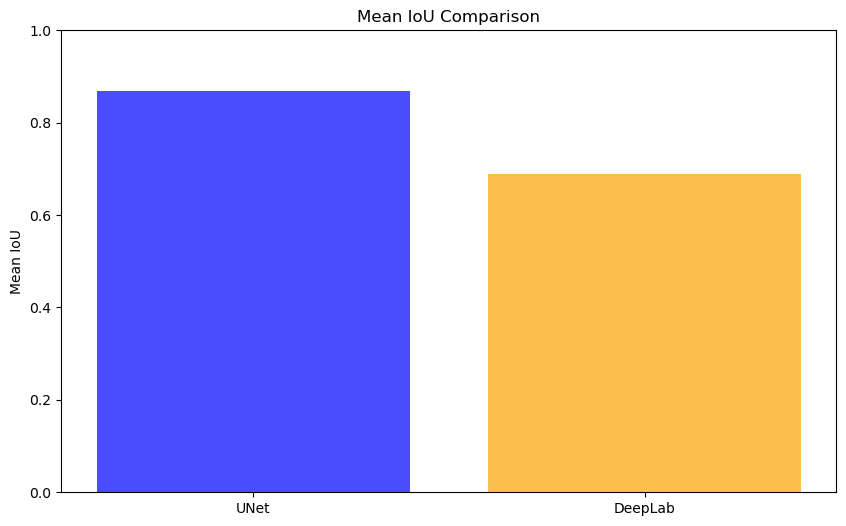

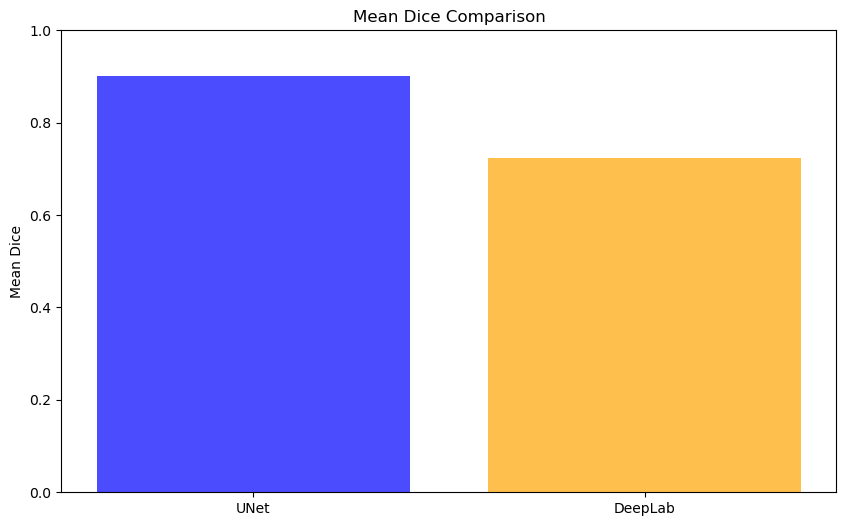

In [117]:
import matplotlib.pyplot as plt
import numpy as np

methods = ['UNet', 'DeepLab']
mean_ious = [0.8692, 0.6880]
mean_dices = [0.9004, 0.7235]

plt.figure(figsize=(10, 6))
plt.bar(methods, mean_ious, color=['blue', 'orange'], alpha=0.7)
plt.ylim(0, 1)
plt.ylabel("Mean IoU")
plt.title("Mean IoU Comparison")
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(methods, mean_dices, color=['blue', 'orange'], alpha=0.7)
plt.ylim(0, 1)
plt.ylabel("Mean Dice")
plt.title("Mean Dice Comparison")
plt.show()
